In [42]:
import pandas as pd
import numpy as np
from functions import *
from models import *
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# set default plotting parameters
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Table of contents**<a id='toc0_'></a>    
- [Create simulated values](#toc1_)    
- [Estimate models with simulated data](#toc2_)    
  - [OLS](#toc2_1_)    
    - [Linear model](#toc2_1_1_)    
    - [Non-normal model](#toc2_1_2_)    
    - [Non-linear model](#toc2_1_3_)    
  - [LASSO (OLS)](#toc2_2_)    
    - [Linear model](#toc2_2_1_)    
    - [Non-normal model](#toc2_2_2_)    
    - [Non-linear model](#toc2_2_3_)    
  - [MLP](#toc2_3_)    
    - [General setup](#toc2_3_1_)    
    - [Linear model](#toc2_3_2_)    
      - [Setup](#toc2_3_2_1_)    
      - [Training](#toc2_3_2_2_)    
      - [Prediction](#toc2_3_2_3_)    
    - [Non-normal model](#toc2_3_3_)    
      - [Setup](#toc2_3_3_1_)    
    - [Non-linear model](#toc2_3_4_)    
      - [Setup](#toc2_3_4_1_)    
      - [Training](#toc2_3_4_2_)    
      - [Prediction](#toc2_3_4_3_)    
- [Results](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Create simulated values](#toc0_)

In [43]:
# load raw data
data = pd.read_csv('data/data.csv')

# financials[(financials['ticker'] == 'INVb.CO^F05')]
baspread = data[(data['ticker'] == 'NOVOb.CO')]['baspread'].values *100
mom12m = data[(data['ticker'] == 'NOVOb.CO')]['mom12m'].values * 100
mom6m = data[(data['ticker'] == 'NOVOb.CO')]['mom6m'].values * 100
mom3m = data[(data['ticker'] == 'NOVOb.CO')]['mom3m'].values * 100
mom1m = data[(data['ticker'] == 'NOVOb.CO')]['mom1m'].values * 100

In [44]:
np.random.seed(42)
theta = 3
lambda_ = 0.05
datapoints = 100
datapoints_train = int(datapoints * 0.7)

# create simulations
x = baspread[-datapoints:]
# x_outofsample = baspread[100:200]

# linear
y1 = theta * x + np.random.normal(0, 0.01, len(x))
y1_train = y1[:datapoints_train]
y1_test = y1[datapoints_train:]

# non-normal error
y2 = theta * x + np.random.standard_t(1, len(x)) * 0.01
y2_train = y2[:datapoints_train]
y2_test = y2[datapoints_train:]


# non-linear
y3 = theta**3 * x**2 + np.abs(x-lambda_) + np.random.normal(0, 0.01, len(x))
y3_train = y3[:datapoints_train]
y3_test = y3[datapoints_train:]

# make x 2 dimensional
x = x.reshape(-1, 1)


# add constant term
x = np.concatenate((np.ones((len(x), 1)), x), axis=1)

# create 10 noise features
noise = np.random.normal(0, np.std(x[1]), size=(len(x), 9))
x_noise = np.concatenate((x, noise), axis=1)


x_train_noise = x_noise[:datapoints_train]
x_test_noise = x_noise[datapoints_train:]
x_train = x[:datapoints_train]
x_test = x[datapoints_train:]



In [45]:
all_y = np.concatenate([y1_train, y1_test, y2_train, y2_test, y3_train, y3_test])
y_min, y_max = all_y.min()-0.025, all_y.max()+0.025

# plot the simulations
plt.subplot(1, 3, 1)
plt.plot(x_train[:,1], y1_train, 'o', label='train data', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y1_test, 'o', label='test data', color='C0', alpha=0.9)
plt.legend(loc='upper left')
plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Normal error')

plt.subplot(1, 3, 2)
plt.plot(x_train[:,1], y2_train, 'o', label='train', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y2_test, 'o', label='test', color='C0', alpha=0.9)
plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('z')
plt.title('Non-normal error')

plt.subplot(1, 3, 3)
plt.plot(x_train[:,1], y3_train, 'o', label='train', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y3_test, 'o', label='test', color='C0', alpha=0.9)
plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('g')
plt.title('Non-linear')

plt.tight_layout()
plt.savefig('output/simulation-data.png', dpi=300)
# plt.show()
plt.close()

# <a id='toc2_'></a>[Estimate models with simulated data](#toc0_)

## <a id='toc2_1_'></a>[OLS](#toc0_)

### <a id='toc2_1_1_'></a>[Linear model](#toc0_)

In [46]:
# linear model
# estimate the parameters
ols_est1 = estimate(y1_train,x_train)

# for i in ols_est1:
#     print(i, ols_est1[i])

print(ols_est1['b_hat'])
print(ols_est1['se'])

ols_pred1 = ols_est1['b_hat'] @ x_test.T

[-0.00521934  3.09651467]
[[0.00265834]
 [0.06072498]]


### <a id='toc2_1_2_'></a>[Non-normal model](#toc0_)

In [47]:
# linear model
# estimate the parameters
ols_est2 = estimate(y2_train,x_train)

print(ols_est2['b_hat'])
print(ols_est2['se'])

ols_pred2 = ols_est2['b_hat'] @ x_test.T

[-0.00516583  3.10081345]
[[0.01170021]
 [0.26727014]]


### <a id='toc2_1_3_'></a>[Non-linear model](#toc0_)

In [48]:
# non-linear model
# estimate the parameters
ols_est3 = estimate(y3_train,x_train)

print(ols_est2['b_hat'])
print(ols_est2['se'])

ols_pred3 = ols_est3['b_hat'] @ x_test.T

[-0.00516583  3.10081345]
[[0.01170021]
 [0.26727014]]


### Noise models

In [49]:
# estimate the parameters and predict
ols_est1n = estimate(y1_train,x_train_noise)
print(ols_est1n['b_hat'])
ols_pred1n = ols_est1n['b_hat'] @ x_test_noise.T

[-6.00551069e-03  3.11268524e+00  1.00558399e-03 -1.56179641e-03
 -2.95929053e-03 -3.51758865e-03 -2.47597488e-03 -7.15030670e-04
  2.16353414e-03 -8.69395144e-04  4.54703172e-05]


In [50]:
# estimate the parameters and predict
ols_est2n = estimate(y2_train,x_train_noise)
print(ols_est2n['b_hat'])
ols_pred2n = ols_est2n['b_hat'] @ x_test_noise.T

[-5.39017493e-03  3.14547356e+00 -1.47479981e-02  2.82914835e-02
  1.69357664e-02 -6.76890099e-04  2.16615445e-03 -4.52499288e-03
 -5.23020216e-03  1.22424172e-03 -1.07327609e-02]


In [51]:
# estimate the parameters and predict
ols_est3n = estimate(y3_train,x_train_noise)
print(ols_est3n['b_hat'])
ols_pred3n = ols_est3n['b_hat'] @ x_test_noise.T

[-2.19796335e-02  2.23010262e+00  5.59344010e-04 -1.62131097e-03
 -1.86262647e-02  4.18353807e-04  2.93943443e-04  5.42957998e-03
 -7.03568576e-04  5.97239242e-03  8.06669092e-03]


## <a id='toc2_2_'></a>[LASSO](#toc0_)

### <a id='toc2_2_1_'></a>[Linear model](#toc0_)

In [52]:
# linear model
# create a grid using numpy.geomspace
penalty_grid = np.geomspace(1e-13, 10, num = 10000)

# estimate the model using LassoCV
fit_CV1 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y1_train)

# # investigate the penalty
# penalty_CV1 = fit_CV1.alpha_ 
# print('Penalty_CV: ', penalty_CV1)

# investigate the coefficients
coeff_CV1 = fit_CV1.coef_
print('Coefficients: ', coeff_CV1)

lasso_pred1 = fit_CV1.predict(x_test)

Coefficients:  [0.         3.09651467]


### <a id='toc2_2_2_'></a>[Non-normal model](#toc0_)

In [53]:
# estimate the model using LassoCV
fit_CV2 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y2_train)

# # investigate the penalty
# penalty_CV2 = fit_CV2.alpha_ 
# print('Penalty_CV: ', penalty_CV2)

# investigate the coefficients
coeff_CV2 = fit_CV2.coef_
print('Coefficients: ', coeff_CV2)

lasso_pred2 = fit_CV2.predict(x_test)

Coefficients:  [0.         3.04002087]


### <a id='toc2_2_3_'></a>[Non-linear model](#toc0_)

In [54]:
# estimate the model using LassoCV
fit_CV3 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y3_train)

# # investigate the penalty
# penalty_CV3 = fit_CV3.alpha_ 
# print('Penalty_CV: ', penalty_CV3)

# investigate the coefficients
coeff_CV = fit_CV3.coef_
print('Coefficients: ', coeff_CV)

lasso_pred3 = fit_CV3.predict(x_test)

Coefficients:  [0.        2.2135834]


### Noise models

In [14]:
# estimate the model using LassoCV
fit_CV1n = LassoCV(cv=5, alphas=penalty_grid).fit(x_train_noise,y1_train)
# investigate the penalty
penalty_CV1n = fit_CV1n.alpha_ 
print('Penalty_CV: ', penalty_CV1n)

# Investigate the coefficients
coeff_CV1n = fit_CV1n.coef_
print('Coefficients: ', coeff_CV1n)
lasso_pred1n = fit_CV1n.predict(x_test_noise)

Penalty_CV:  2.0607789195148455e-05
Coefficients:  [ 0.00000000e+00  3.02754103e+00 -3.15590635e-03  0.00000000e+00
  1.28315117e-02 -2.69616518e-02 -0.00000000e+00  5.36476711e-03
  4.69636597e-03 -2.10289257e-02 -1.69276119e-03]


In [15]:
# estimate the model using LassoCV
fit_CV2n = LassoCV(cv=5, alphas=penalty_grid).fit(x_train_noise,y2_train)
# investigate the penalty
penalty_CV2n = fit_CV2n.alpha_ 
print('Penalty_CV: ', penalty_CV2n)

# Investigate the coefficients
coeff_CV2n = fit_CV2n.coef_
print('Coefficients: ', coeff_CV2n)
lasso_pred2n = fit_CV2n.predict(x_test_noise)

Penalty_CV:  2.0278260745220603e-05
Coefficients:  [ 0.          3.29821825 -0.02660369  0.0037007  -0.03917461  0.06039521
 -0.06770024  0.07915919 -0.01425478  0.07323447 -0.08058343]


In [16]:
# estimate the model using LassoCV
fit_CV3n = LassoCV(cv=5, alphas=penalty_grid).fit(x_train_noise,y3_train)
# investigate the penalty
penalty_CV3n = fit_CV3n.alpha_ 
print('Penalty_CV: ', penalty_CV3n)

# Investigate the coefficients
coeff_CV3n = fit_CV3n.coef_
print('Coefficients: ', coeff_CV3n)
lasso_pred3n = fit_CV3n.predict(x_test_noise)

Penalty_CV:  7.910242888878624e-06
Coefficients:  [ 0.00000000e+00  2.30005597e+00  8.87797212e-03  3.09722324e-02
  8.31836338e-02 -6.91448675e-03 -4.38711004e-02 -1.00328591e-02
 -9.03663418e-04  1.00729967e-02 -4.80455209e-02]


## <a id='toc2_3_'></a>[MLP](#toc0_)

### <a id='toc2_3_1_'></a>[General setup](#toc0_)

In [17]:
# remove constant as bias is included in the model
scaler_x, scaler_y1, scaler_y2, scaler_y3 = StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler()
x_train_mlp = scaler_x.fit_transform(x_train[:,1][:9*(datapoints_train//10)].reshape(-1, 1))
x_val_mlp = scaler_x.transform(x_train[:,1][9*(datapoints_train//10):].reshape(-1, 1))
x_test_mlp = scaler_x.transform(x_test[:,1].reshape(-1, 1))

y1_train_mlp = scaler_y1.fit_transform(y1_train[:9*(datapoints_train//10)].reshape(-1, 1))
y1_val_mlp = scaler_y1.transform(y1_train[9*(datapoints_train//10):].reshape(-1, 1))
y1_test_mlp = scaler_y1.transform(y1_test.reshape(-1, 1))

y2_train_mlp = scaler_y2.fit_transform(y2_train[:9*(datapoints_train//10)].reshape(-1, 1))
y2_val_mlp = scaler_y2.transform(y2_train[9*(datapoints_train//10):].reshape(-1, 1))
y2_test_mlp = scaler_y2.transform(y2_test.reshape(-1, 1))

y3_train_mlp = scaler_y3.fit_transform(y3_train[:9*(datapoints_train//10)].reshape(-1, 1))
y3_val_mlp = scaler_y3.transform(y3_train[9*(datapoints_train//10):].reshape(-1, 1))
y3_test_mlp = scaler_y3.transform(y3_test.reshape(-1, 1))

In [18]:
# moving to metal or CUDA GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

# general hyperparameters
input_dim = x_train_mlp.shape[1]
hidden_depth = 1 # excluding output layer
hidden_width = 2 # int for all being equal width; list for different widths
learning_rate = 1e-3
activation_fun = nn.ReLU # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU nn.Identity

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 0 # 1e-4
lambda_l2 = 0 # 1e-4

# general parmeters
patience = 1000
print_freq = 100
epochs = 500

Using device: mps


### <a id='toc2_3_2_'></a>[Linear model](#toc0_)

In [58]:
# linear model
np.random.seed(42)
torch.manual_seed(42)
model1 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp, y1_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y1_val_mlp)
best_model1 = train_mlp(train_dataset,
          val_dataset,
          model1,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=None,
          shuffle_train=False,
          shuffle_val=False)

Epoch 100/500  - Train Loss: 2.80232E-02  - Val Loss: 3.25425E-02
Epoch 200/500  - Train Loss: 2.40177E-02  - Val Loss: 3.19270E-02
Epoch 300/500  - Train Loss: 2.40197E-02  - Val Loss: 3.19789E-02
Epoch 400/500  - Train Loss: 2.40197E-02  - Val Loss: 3.20052E-02
Epoch 500/500  - Train Loss: 2.40194E-02  - Val Loss: 3.20087E-02


In [ ]:
# non-normal model
np.random.seed(42)
torch.manual_seed(42)
model2 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp, y2_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y2_val_mlp)
best_model2 = train_mlp(train_dataset,
          val_dataset,
          model2,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=None,
          shuffle_train=False,
          shuffle_val=False)

In [ ]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)
model3 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp, y3_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y3_val_mlp)
best_model3 = train_mlp(train_dataset,
          val_dataset,
          model3,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=None,
          shuffle_train=False,
          shuffle_val=False)

In [20]:
# linear model
np.random.seed(42)
torch.manual_seed(42)

# create dataset objects for training and validation
train_dataset = MLPdataset(x_train_mlp, y1_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y1_val_mlp)
# dataloaders for batching
train_loader = DataLoader(train_dataset, 
                        #   batch_size=64, 
                        #   shuffle=True
                          )
val_loader = DataLoader(val_dataset, 
                        # batch_size=64, 
                        # shuffle=False
                        )

model1 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)

optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

best_val_loss = float('inf')
best_model1 = None


#### <a id='toc2_3_2_2_'></a>[Training](#toc0_)

In [21]:
for epoch in range(epochs):
    model1.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model1(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model1, lambda_l1)
        loss += l2_regularization(model1, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    
    # validation
    model1.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model1(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model1, lambda_l1)
            loss += l2_regularization(model1, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % print_freq == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5E}, Validation Loss: {val_loss:.5E}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model1 = model1
        # torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5E}")
            break
    

Epoch 100/500 - Train Loss: 3.05457E-02, Validation Loss: 2.49014E-02
Epoch 200/500 - Train Loss: 2.38655E-02, Validation Loss: 2.95672E-02
Epoch 300/500 - Train Loss: 2.33090E-02, Validation Loss: 3.17013E-02
Epoch 400/500 - Train Loss: 2.32771E-02, Validation Loss: 3.22265E-02
Epoch 500/500 - Train Loss: 2.32756E-02, Validation Loss: 3.23671E-02


#### <a id='toc2_3_2_3_'></a>[Prediction](#toc0_)

In [22]:
test_dataset = MLPdataset(x_test_mlp, y1_test_mlp)    # if you don’t have y_test, you can pass dummy zeros
test_loader = DataLoader(test_dataset, 
                        #  batch_size=64, 
                         shuffle=False
                         )

# run the model in eval mode and collect predictions
best_model1.eval()
mlp_pred1 = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = best_model1(batch_X) # shape: (batch_size, 1)
        
        # Move back to CPU and flatten
        preds = outputs.cpu().numpy().flatten()
        mlp_pred1.extend(preds)

# convert to array
mlp_pred1_scaled = np.array(mlp_pred1)
mlp_pred1 = scaler_y1.inverse_transform(mlp_pred1_scaled.reshape(-1, 1)).flatten()

### <a id='toc2_3_3_'></a>[Non-normal model](#toc0_)


#### <a id='toc2_3_3_1_'></a>[Setup](#toc0_)

In [23]:
np.random.seed(42)
torch.manual_seed(42)

# create dataset objects for training and validation
train_dataset = MLPdataset(x_train_mlp, y2_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y2_val_mlp)
# dataloaders for batching
train_loader = DataLoader(train_dataset, 
                        #   batch_size=64, 
                        #   shuffle=True
                          )
val_loader = DataLoader(val_dataset, 
                        # batch_size=64, 
                        # shuffle=False
                        )

model2 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)

optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

best_val_loss = float('inf')
best_model2 = None

In [24]:
for epoch in range(epochs):
    model2.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model2(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model2, lambda_l1)
        loss += l2_regularization(model2, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    
    # validation
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model2(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model2, lambda_l1)
            loss += l2_regularization(model2, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % print_freq == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5E}, Validation Loss: {val_loss:.5E}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model2 = model2
        # torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5E}")
            break
    

Epoch 100/500 - Train Loss: 3.58676E-01, Validation Loss: 1.49474E-01
Epoch 200/500 - Train Loss: 3.43283E-01, Validation Loss: 1.57468E-01
Epoch 300/500 - Train Loss: 3.41568E-01, Validation Loss: 1.63590E-01
Epoch 400/500 - Train Loss: 3.41071E-01, Validation Loss: 1.66479E-01
Epoch 500/500 - Train Loss: 3.40889E-01, Validation Loss: 1.70413E-01


In [25]:
test_dataset = MLPdataset(x_test_mlp, y2_test_mlp)    # if you don’t have y_test, you can pass dummy zeros
test_loader = DataLoader(test_dataset, 
                        #  batch_size=64, 
                         shuffle=False
                         )

# run the model in eval mode and collect predictions
best_model2.eval()
mlp_pred2 = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = best_model2(batch_X) # shape: (batch_size, 1)
        
        # Move back to CPU and flatten
        preds = outputs.cpu().numpy().flatten()
        mlp_pred2.extend(preds)

# convert to array
mlp_pred2_scaled = np.array(mlp_pred2)
mlp_pred2 = scaler_y2.inverse_transform(mlp_pred2_scaled.reshape(-1, 1)).flatten()

### <a id='toc2_3_4_'></a>[Non-linear model](#toc0_)

#### <a id='toc2_3_4_1_'></a>[Setup](#toc0_)

In [26]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)

# train_dataset = MLPdataset(x_train_mlp, y3_train_mlp) 

# create dataset objects for training and validation
train_dataset = MLPdataset(x_train_mlp, y3_train_mlp) # removing constant term
val_dataset = MLPdataset(x_val_mlp, y3_val_mlp) # removing constant term
# dataloaders for batching
train_loader = DataLoader(train_dataset, 
                        #   batch_size=64, 
                        #   shuffle=True
                          )
val_loader = DataLoader(val_dataset, 
                        # batch_size=64, 
                        # shuffle=False
                        )

model3 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width,activation=activation_fun).to(device)

optimizer = optim.Adam(model3.parameters(), lr=learning_rate)

best_val_loss = float('inf')
best_model3 = None

#### <a id='toc2_3_4_2_'></a>[Training](#toc0_)

In [27]:
for epoch in range(epochs):
    model3.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model3(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model3, lambda_l1)
        loss += l2_regularization(model3, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)


    # validation
    model3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model3(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model3, lambda_l1)
            loss += l2_regularization(model3, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % print_freq == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5E}, Validation Loss: {val_loss:.5E}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model3 = model3
        # torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5E}")
            break
# best_model3 = model3
    

Epoch 100/500 - Train Loss: 8.10356E-02, Validation Loss: 1.47762E-02
Epoch 200/500 - Train Loss: 4.72705E-02, Validation Loss: 1.42557E-02
Epoch 300/500 - Train Loss: 4.48139E-02, Validation Loss: 1.99305E-02
Epoch 400/500 - Train Loss: 4.34976E-02, Validation Loss: 2.66965E-02
Epoch 500/500 - Train Loss: 4.32580E-02, Validation Loss: 2.85318E-02


#### <a id='toc2_3_4_3_'></a>[Prediction](#toc0_)

In [28]:
test_dataset = MLPdataset(x_test_mlp, y3_test_mlp)
test_loader = DataLoader(test_dataset, 
                        #  batch_size=64, 
                         shuffle=False
                         )

# run the model in eval mode and collect predictions
best_model3.eval()
mlp_pred3 = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = best_model3(batch_X) # shape: (batch_size, 1)
        
        # Move back to CPU and flatten
        preds = outputs.cpu().numpy().flatten()
        mlp_pred3.extend(preds)

# convert to array
mlp_pred3_scaled = np.array(mlp_pred3)
mlp_pred3 = scaler_y3.inverse_transform(mlp_pred3_scaled.reshape(-1, 1)).flatten()

## Noise models

In [29]:
lambda_l1 = 1e-4

In [30]:
# remove constant as bias is included in the model
scaler_x, scaler_y1, scaler_y2, scaler_y3 = StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler()
x_train_mlpn = scaler_x.fit_transform(x_train_noise[:,1:][:9*(datapoints_train//10)].reshape(-1, 1))
x_val_mlpn = scaler_x.transform(x_train_noise[:,1:][9*(datapoints_train//10):].reshape(-1, 1))
x_test_mlpn = scaler_x.transform(x_test_noise[:,1:].reshape(-1, 1))

y1_train_mlp = scaler_y1.fit_transform(y1_train[:9*(datapoints_train//10)].reshape(-1, 1))
y1_val_mlp = scaler_y1.transform(y1_train[9*(datapoints_train//10):].reshape(-1, 1))
y1_test_mlp = scaler_y1.transform(y1_test.reshape(-1, 1))

y2_train_mlp = scaler_y2.fit_transform(y2_train[:9*(datapoints_train//10)].reshape(-1, 1))
y2_val_mlp = scaler_y2.transform(y2_train[9*(datapoints_train//10):].reshape(-1, 1))
y2_test_mlp = scaler_y2.transform(y2_test.reshape(-1, 1))

y3_train_mlp = scaler_y3.fit_transform(y3_train[:9*(datapoints_train//10)].reshape(-1, 1))
y3_val_mlp = scaler_y3.transform(y3_train[9*(datapoints_train//10):].reshape(-1, 1))
y3_test_mlp = scaler_y3.transform(y3_test.reshape(-1, 1))

In [31]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)

# create dataset objects for training and validation
train_dataset = MLPdataset(x_train_mlpn, y1_train_mlp) # removing constant term
val_dataset = MLPdataset(x_val_mlpn, y1_val_mlp) # removing constant term
# dataloaders for batching
train_loader = DataLoader(train_dataset, 
                        #   batch_size=64, 
                        #   shuffle=True
                          )
val_loader = DataLoader(val_dataset, 
                        # batch_size=64, 
                        # shuffle=False
                        )

model1n = MLPModel(input_dim,depth=hidden_depth,width=hidden_width,activation=activation_fun).to(device)

optimizer = optim.Adam(model1n.parameters(), lr=learning_rate)

best_val_loss = float('inf')
best_model1n = None

for epoch in range(epochs):
    model1n.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model1n(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model1n, lambda_l1)
        loss += l2_regularization(model1n, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    
    # validation
    model1n.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model1n(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model1n, lambda_l1)
            loss += l2_regularization(model1n, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % print_freq == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5E}, Validation Loss: {val_loss:.5E}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model1n = model1n
        # torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5E}")
            break

Epoch 100/500 - Train Loss: 9.47099E-01, Validation Loss: 3.60840E-01
Epoch 200/500 - Train Loss: 9.45336E-01, Validation Loss: 3.65546E-01
Epoch 300/500 - Train Loss: 9.45211E-01, Validation Loss: 3.66213E-01
Epoch 400/500 - Train Loss: 9.45185E-01, Validation Loss: 3.66569E-01
Epoch 500/500 - Train Loss: 9.45184E-01, Validation Loss: 3.66227E-01


In [32]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)

# create dataset objects for training and validation
train_dataset = MLPdataset(x_train_mlpn, y2_train_mlp) # removing constant term
val_dataset = MLPdataset(x_val_mlpn, y2_val_mlp) # removing constant term
# dataloaders for batching
train_loader = DataLoader(train_dataset, 
                        #   batch_size=64, 
                        #   shuffle=True
                          )
val_loader = DataLoader(val_dataset, 
                        # batch_size=64, 
                        # shuffle=False
                        )

model2n = MLPModel(input_dim,depth=hidden_depth,width=hidden_width,activation=activation_fun).to(device)

optimizer = optim.Adam(model2n.parameters(), lr=learning_rate)

best_val_loss = float('inf')
best_model2n = None

for epoch in range(epochs):
    model2n.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model2n(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model2n, lambda_l1)
        loss += l2_regularization(model2n, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    
    # validation
    model2n.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model2n(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model2n, lambda_l1)
            loss += l2_regularization(model2n, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % print_freq == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5E}, Validation Loss: {val_loss:.5E}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model2n = model2n
        # torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5E}")
            break
    

Epoch 100/500 - Train Loss: 9.76794E-01, Validation Loss: 2.77172E-01
Epoch 200/500 - Train Loss: 9.76628E-01, Validation Loss: 2.83050E-01
Epoch 300/500 - Train Loss: 9.76579E-01, Validation Loss: 2.85046E-01
Epoch 400/500 - Train Loss: 9.76556E-01, Validation Loss: 2.85907E-01
Epoch 500/500 - Train Loss: 9.76543E-01, Validation Loss: 2.86204E-01


In [33]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)

# create dataset objects for training and validation
train_dataset = MLPdataset(x_train_mlpn, y3_train_mlp) # removing constant term
val_dataset = MLPdataset(x_val_mlpn, y3_val_mlp) # removing constant term
# dataloaders for batching
train_loader = DataLoader(train_dataset, 
                        #   batch_size=64, 
                        #   shuffle=True
                          )
val_loader = DataLoader(val_dataset, 
                        # batch_size=64, 
                        # shuffle=False
                        )

model3n = MLPModel(input_dim,depth=hidden_depth,width=hidden_width,activation=activation_fun).to(device)

optimizer = optim.Adam(model3n.parameters(), lr=learning_rate)

best_val_loss = float('inf')
best_model3n = None

for epoch in range(epochs):
    model3n.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model3n(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model3n, lambda_l1)
        loss += l2_regularization(model3n, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    
    # validation
    model3n.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model3n(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model3n, lambda_l1)
            loss += l2_regularization(model3n, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % print_freq == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5E}, Validation Loss: {val_loss:.5E}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model3n = model3n
        # torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5E}")
            break

Epoch 100/500 - Train Loss: 9.60334E-01, Validation Loss: 4.26415E-01
Epoch 200/500 - Train Loss: 9.59415E-01, Validation Loss: 4.45495E-01
Epoch 300/500 - Train Loss: 9.59104E-01, Validation Loss: 4.48241E-01
Epoch 400/500 - Train Loss: 9.58960E-01, Validation Loss: 4.49625E-01
Epoch 500/500 - Train Loss: 9.58855E-01, Validation Loss: 4.49881E-01


In [34]:
test_dataset1 = MLPdataset(x_test_mlpn, y1_test_mlp)
test_dataset2 = MLPdataset(x_test_mlpn, y2_test_mlp)
test_dataset3 = MLPdataset(x_test_mlpn, y3_test_mlp)
test_loader1 = DataLoader(test_dataset1, 
                        #  batch_size=64, 
                         shuffle=False
                         )
test_loader2 = DataLoader(test_dataset2,
                        #  batch_size=64, 
                         shuffle=False
                         )
test_loader3 = DataLoader(test_dataset3,
                        #  batch_size=64, 
                         shuffle=False
                         )

# run the model in eval mode and collect predictions
for model in [best_model1n, best_model2n, best_model3n]:
    model.eval()

mlp_pred1n = []
with torch.no_grad():
    for batch_X, batch_y in test_loader1:
        batch_X = batch_X.to(device)
        outputs = best_model1n(batch_X) # shape: (batch_size, 1)
        
        # Move back to CPU and flatten
        preds = outputs.cpu().numpy().flatten()
        mlp_pred1n.extend(preds)

mlp_pred2n = []
with torch.no_grad():
    for batch_X, batch_y in test_loader2:
        batch_X = batch_X.to(device)
        outputs = best_model2n(batch_X) # shape: (batch_size, 1)
        
        # Move back to CPU and flatten
        preds = outputs.cpu().numpy().flatten()
        mlp_pred2n.extend(preds)

mlp_pred3n = []
with torch.no_grad():
    for batch_X, batch_y in test_loader3:
        batch_X = batch_X.to(device)
        outputs = best_model3n(batch_X) # shape: (batch_size, 1)
        
        # Move back to CPU and flatten
        preds = outputs.cpu().numpy().flatten()
        mlp_pred3n.extend(preds)

# convert to array
mlp_pred1n_scaled = np.array(mlp_pred1n)
mlp_pred1n = scaler_y1.inverse_transform(mlp_pred1n_scaled.reshape(-1, 1)).flatten()
mlp_pred2n_scaled = np.array(mlp_pred2n)
mlp_pred2n = scaler_y2.inverse_transform(mlp_pred2n_scaled.reshape(-1, 1)).flatten()
mlp_pred3n_scaled = np.array(mlp_pred3n)
mlp_pred3n = scaler_y3.inverse_transform(mlp_pred3n_scaled.reshape(-1, 1)).flatten()

# <a id='toc3_'></a>[Results](#toc0_)

In [35]:
n_train = np.arange(len(x_train))
n_test  = np.arange(len(x_train), len(x))
n_full  = np.arange(len(x))

plt.plot(n_full, y1, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred1, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred1, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred1, label='mlp', color='C8', alpha=0.7)

plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)

plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Data Generating Process")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/linear.png', dpi=300)
# plt.show()
plt.close()

In [36]:
n_train = np.arange(len(x_train))
n_test  = np.arange(len(x_train), len(x))
n_full  = np.arange(len(x))

plt.plot(n_full, y2, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred2, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred2, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred2, label='mlp', color='C8', alpha=0.7)
plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Data Generating Process w. non-normal error")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/linear-non-normal.png', dpi=300)
# plt.show()
plt.close()

In [37]:
plt.plot(n_full, y3, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred3, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred3, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred3, label='mlp', color='C8', alpha=0.7)
plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Non-linear Data Generating Process")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/non-linear-simul.png', dpi=300)
# plt.show()
plt.close()

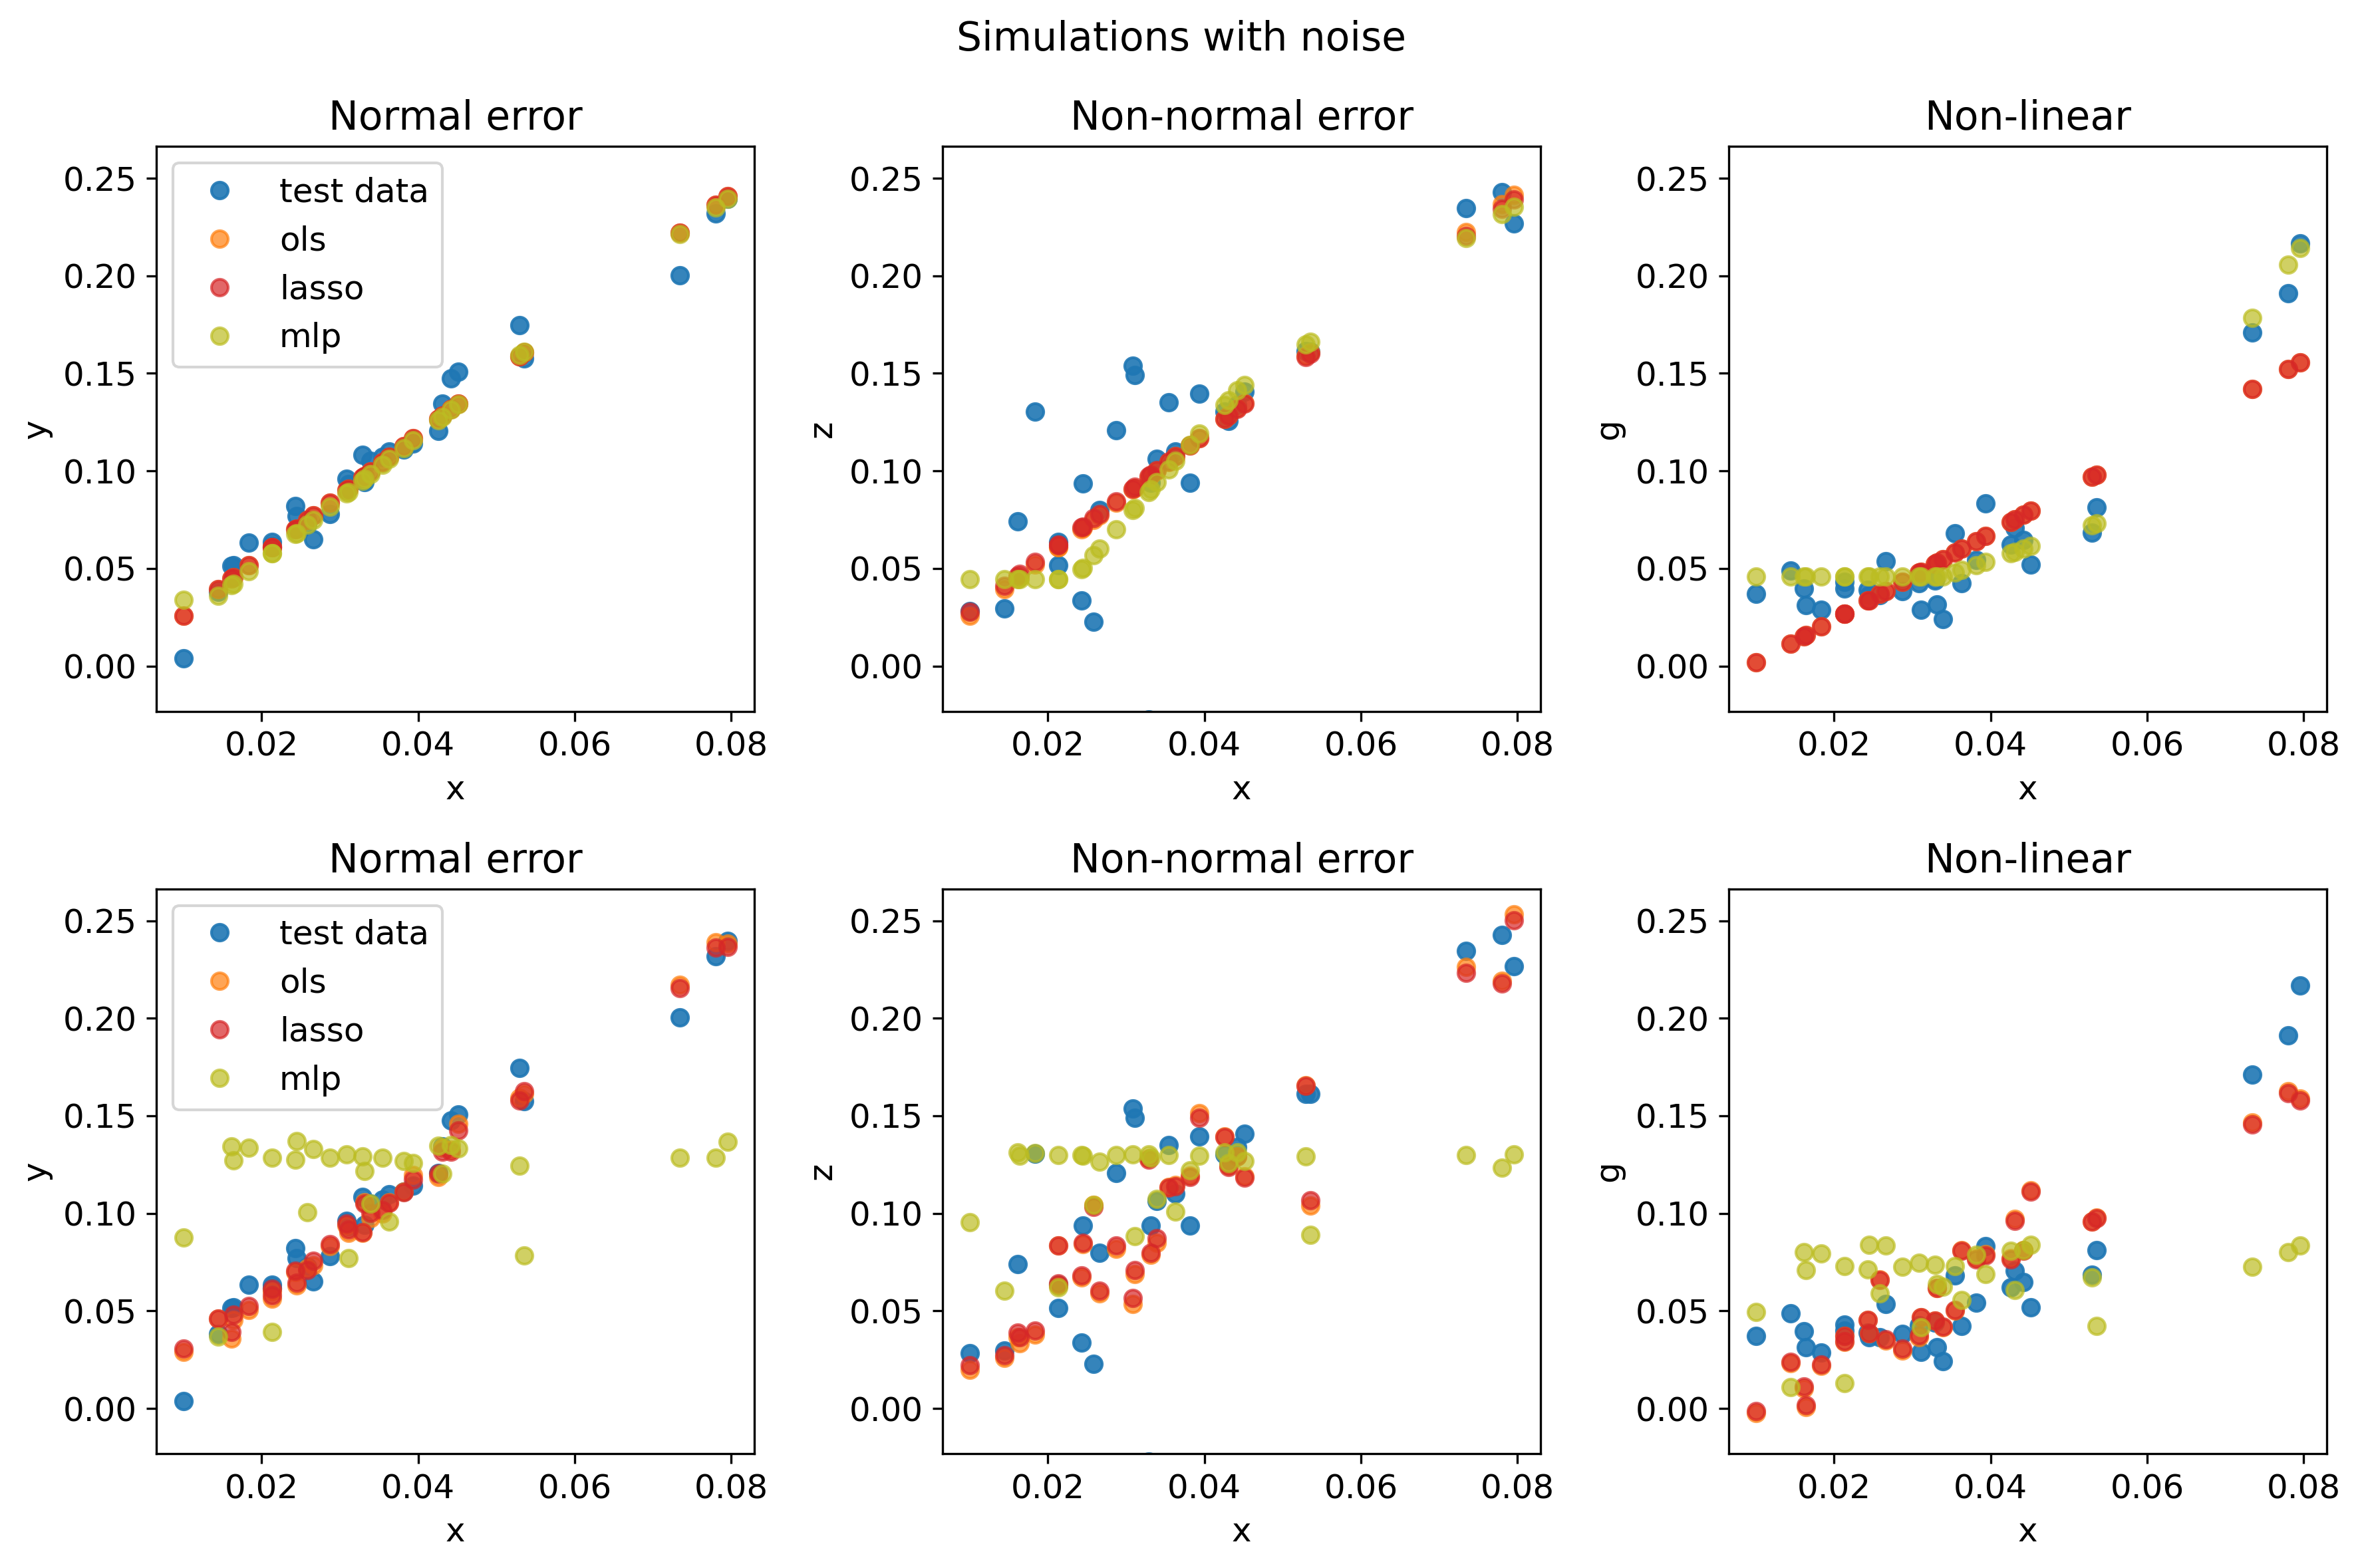

In [ ]:
all_y = np.concatenate([y1_test, ols_pred1, lasso_pred1, mlp_pred1,
                        ols_pred2, lasso_pred2, mlp_pred2,
                        ols_pred3, lasso_pred3, mlp_pred3])
y_min, y_max = all_y.min()-0.025, all_y.max()+0.025

# set figure size
fig = plt.figure(figsize=(12, 8))

# plot the simulations
plt.subplot(2, 3, 1)
plt.plot(x_test[:,1], y1_test, 'o', label='test data', color='C0', alpha=0.9)
plt.plot(x_test[:,1], ols_pred1, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test[:,1], lasso_pred1, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test[:,1], mlp_pred1, 'o', label='mlp', color='C8', alpha=0.7)
plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Normal error')

plt.subplot(2, 3, 2)
plt.plot(x_test[:,1], y2_test, 'o', label='test', color='C0', alpha=0.9)
plt.plot(x_test[:,1], ols_pred2, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test[:,1], lasso_pred2, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test[:,1], mlp_pred2, 'o', label='mlp', color='C8', alpha=0.7)
plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('z')
plt.title('Non-normal error')

plt.subplot(2, 3, 3)
plt.plot(x_test[:,1], y3_test, 'o', label='test', color='C0', alpha=0.9)
plt.plot(x_test[:,1], ols_pred3, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test[:,1], lasso_pred3, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test[:,1], mlp_pred3, 'o', label='mlp',  color='C8', alpha=0.7)
plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('g')
plt.title('Non-linear')

plt.subplot(2, 3, 4)
plt.plot(x_test_noise[:,1], y1_test, 'o', label='test data', color='C0', alpha=0.9)
plt.plot(x_test_noise[:,1], ols_pred1n, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test_noise[:,1], lasso_pred1n, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test_noise[:,1], mlp_pred1n, 'o', label='mlp', color='C8', alpha=0.7)
plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Normal error')

plt.subplot(2, 3, 5)
plt.plot(x_test_noise[:,1], y2_test, 'o', label='test', color='C0', alpha=0.9)
plt.plot(x_test_noise[:,1], ols_pred2n, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test_noise[:,1], lasso_pred2n, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test_noise[:,1], mlp_pred2n, 'o', label='mlp', color='C8', alpha=0.7)
plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('z')
plt.title('Non-normal error')

plt.subplot(2, 3, 6)
plt.plot(x_test_noise[:,1], y3_test, 'o', label='test', color='C0', alpha=0.9)
plt.plot(x_test_noise[:,1], ols_pred3n, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test_noise[:,1], lasso_pred3n, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test_noise[:,1], mlp_pred3n, 'o', label='mlp',  color='C8', alpha=0.7)
plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('g')
plt.title('Non-linear')
plt.suptitle('Simulations with noise')
plt.tight_layout()
plt.savefig('output/simulation-scatter.png')
plt.show()
plt.close()

In [39]:
# calculate the root mean squared error for each
rmse_ols1 = np.sqrt(np.mean((y1_test - ols_pred1)**2))
rmse_lasso1 = np.sqrt(np.mean((y1_test - lasso_pred1)**2))
rmse_mlp1 = np.sqrt(np.mean((y1_test - mlp_pred1)**2))

rmse_ols2 = np.sqrt(np.mean((y2_test - ols_pred2)**2))
rmse_lasso2 = np.sqrt(np.mean((y2_test - lasso_pred2)**2))
rmse_mlp2 = np.sqrt(np.mean((y2_test - mlp_pred2)**2))

rmse_ols3 = np.sqrt(np.mean((y3_test - ols_pred3)**2))
rmse_lasso3 = np.sqrt(np.mean((y3_test - lasso_pred3)**2))
rmse_mlp3 = np.sqrt(np.mean((y3_test - mlp_pred3)**2))

# calculate mean absolute error
mae_ols1 = np.mean(np.abs(y1_test - ols_pred1))
mae_lasso1 = np.mean(np.abs(y1_test - lasso_pred1))
mae_mlp1 = np.mean(np.abs(y1_test - mlp_pred1))

mae_ols2 = np.mean(np.abs(y2_test - ols_pred2))
mae_lasso2 = np.mean(np.abs(y2_test - lasso_pred2))
mae_mlp2 = np.mean(np.abs(y2_test - mlp_pred2))

mae_ols3 = np.mean(np.abs(y3_test - ols_pred3))
mae_lasso3 = np.mean(np.abs(y3_test - lasso_pred3))
mae_mlp3 = np.mean(np.abs(y3_test - mlp_pred3))

models = ['OLS', 'LASSO', 'MLP']
metrics = {'*RMSE*Normal error':[rmse_ols1, rmse_lasso1, rmse_mlp1],
           '*RMSE*Non-normal error':[rmse_ols2, rmse_lasso2, rmse_mlp2],
           '*RMSE*Non-linear':[rmse_ols3, rmse_lasso3, rmse_mlp3],
           '*MAE*Normal error':[mae_ols1, mae_lasso1, mae_mlp1],
           '*MAE*Non-normal error':[mae_ols2, mae_lasso2, mae_mlp2],
           '*MAE*Non-linear':[mae_ols3, mae_lasso3, mae_mlp3]}

tab = latex_table_grouped(models,metrics)

# print(tab)
with open('output/simulation_table.tex', 'w') as f:
    f.write(tab)
